##### Model Training and Biomarker Discovery

In [38]:
#import libaries
import pandas as pd
import numpy as np
import glob
import os
import joblib
from pathlib import Path
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA   
import matplotlib.pyplot as plt
import seaborn as sns   

print("Libraries imported successfully.")

Libraries imported successfully.


### Analysis of protein coding genes for biomarker discovery


In [39]:
import joblib
import pandas as pd

# Expression matrix (protein-coding only)
file_path_X = r"C:\Projects\BRCA_ML_Project\Data\Output\X_expression_annotated_collapsed_protein_coding.pkl"
X_expr_pc = joblib.load(file_path_X)

print(type(X_expr_pc))        # Should be DataFrame
print(X_expr_pc.shape)        # (samples x genes)
print(X_expr_pc.index[:10])   # Check sample IDs


<class 'pandas.core.frame.DataFrame'>
(1107, 16858)
Index(['TCGA-D8-A146-01A', 'TCGA-AQ-A0Y5-01A', 'TCGA-C8-A274-01A',
       'TCGA-BH-A0BD-01A', 'TCGA-B6-A1KC-01B', 'TCGA-AC-A62V-01A',
       'TCGA-AO-A0J5-01A', 'TCGA-BH-A0B1-01A', 'TCGA-A2-A0YM-01A',
       'TCGA-AO-A03N-01B'],
      dtype='object')


In [40]:
# Labels (subtypes)
file_path_y = r"C:\Projects\BRCA_ML_Project\Data\Output\y_subtype.pkl"
y_expr_pc = joblib.load(file_path_y)

print(type(y_expr_pc))
if isinstance(y_expr_pc, pd.DataFrame):
    print(y_expr_pc.head())
elif isinstance(y_expr_pc, pd.Series):
    print(y_expr_pc[:10])


<class 'pandas.core.series.Series'>
TCGA-D8-A146-01A     LumA
TCGA-AQ-A0Y5-01A     LumA
TCGA-C8-A274-01A     LumB
TCGA-BH-A0BD-01A     LumB
TCGA-B6-A1KC-01B     LumB
TCGA-AC-A62V-01A     LumB
TCGA-AO-A0J5-01A     LumA
TCGA-BH-A0B1-01A     LumA
TCGA-A2-A0YM-01A    Basal
TCGA-AO-A03N-01B     LumB
Name: subtype, dtype: object


In [41]:
# Ensure y has sample IDs as index
if isinstance(y_expr_pc, pd.DataFrame):
    # Suppose your sample ID column is 'sample_id' and subtype column is 'subtype'
    y_expr_pc.index = y_expr_pc['sample_id']
    y_expr_pc = y_expr_pc['subtype']  # convert to Series

# Align samples
common_index = X_expr_pc.index.intersection(y_expr_pc.index)
X_expr_pc_aligned = X_expr_pc.loc[common_index]
y_expr_pc_aligned = y_expr_pc.loc[common_index]

print("Aligned shapes:")
print("X:", X_expr_pc_aligned.shape)
print("y:", y_expr_pc_aligned.shape)


Aligned shapes:
X: (1089, 16858)
y: (1089,)


In [ ]:
#Verfiy the split data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_expr_pc_aligned,
    y_expr_pc_aligned,
    test_size=0.2,
    stratify=y_expr_pc_aligned,
    random_state=42
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


Training set shape: (871, 16858)
Test set shape: (218, 16858)


In [ ]:
# Training model (Random Forest)
from sklearn.ensemble import ExtraTreesClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

# Lightweight feature selection
feat_selector = ExtraTreesClassifier(n_estimators=50, random_state=42, n_jobs=3)
feat_selector.fit(X_train, y_train)
importances = pd.Series(feat_selector.feature_importances_, index=X_train.columns)
top_features = importances.sort_values(ascending=False).head(250).index

X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

# Hyperparameter tuning + final training in one step
param_dist = {
    'n_estimators': [150, 200],
    'max_depth': [15, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4],
    'max_features': ['sqrt', 'log2']
}

brf = BalancedRandomForestClassifier(
    random_state=42,
    class_weight='balanced',
    n_jobs=3
)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    brf,
    param_distributions=param_dist,
    n_iter=10,
    scoring='balanced_accuracy',
    cv=cv,
    n_jobs=3,
    verbose=1,
    random_state=42
)

# This single fit performs hyperparameter search on top features
random_search.fit(X_train_top, y_train)
best_brf = random_search.best_estimator_


Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [45]:
# Train final model
brf.fit(X_train, y_train) 

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,False
,oob_score,False


In [ ]:
# Use only the selected top features to give predictions
y_pred_test = best_brf.predict(X_test_top)
y_pred_prob_test = best_brf.predict_proba(X_test_top)


In [ ]:
#Model Metrics evaluation
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np

classes = np.unique(y_train)
y_test_bin = label_binarize(y_test, classes=classes)

metrics = {
    "Test Overall Accuracy": accuracy_score(y_test, y_pred_test),
    "Test Balanced Accuracy": balanced_accuracy_score(y_test, y_pred_test),
    "Test Macro F1": f1_score(y_test, y_pred_test, average='macro'),
    "Test ROC-AUC": roc_auc_score(y_test_bin, y_pred_prob_test, average='macro', multi_class='ovr')
}

for k, v in metrics.items():
    print(f"{k}: {v:.4f}")


Test Overall Accuracy: 0.8303
Test Balanced Accuracy: 0.8895
Test Macro F1: 0.8063
Test ROC-AUC: 0.9784


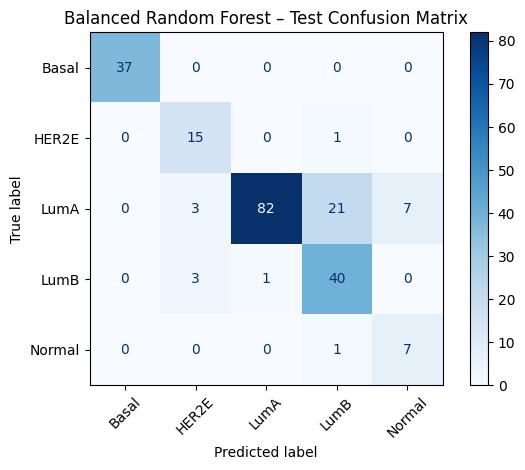

In [ ]:
#Confusion metrix plot
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_test,
    display_labels=best_brf.classes_,
    cmap="Blues",
    xticks_rotation=45
)
plt.title("Balanced Random Forest – Test Confusion Matrix")
plt.tight_layout()
plt.show()


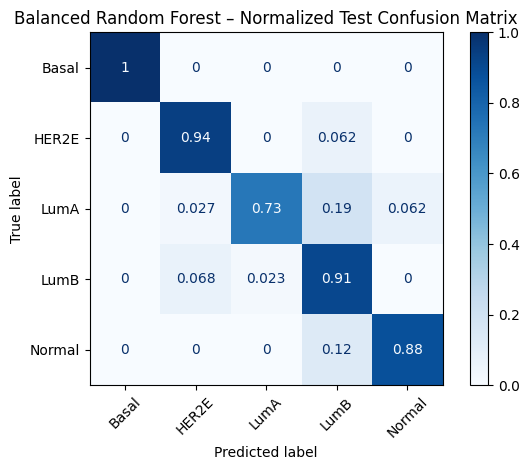

In [ ]:
#Normalized plot of confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Normalize per true class (row-wise)
disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_test,
    display_labels=best_brf.classes_,
    cmap="Blues",
    xticks_rotation=45,
    normalize='true'  # <-- normalize per row
)

plt.title("Balanced Random Forest – Normalized Test Confusion Matrix")
plt.tight_layout()
plt.show()


============================================================

In [50]:
#Gini Importance (Top Genes – Fast Screening)
import pandas as pd

# Extract Gini importance
gini_importance = pd.Series(
    brf.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

# Top genes
top_gini = gini_importance.head(30)

print(top_gini)


PTPRZ1      0.010583
GRIA4       0.006977
TRABD2B     0.006900
OSR1        0.006693
BCL11A      0.006615
RHOJ        0.006467
TAGLN       0.006462
OVCH2       0.006308
SCN4B       0.006132
KRT5        0.005704
SMYD1       0.005271
CENPL       0.004872
SEMA3G      0.004806
SERPINF2    0.004642
TOP2A       0.004631
ID4         0.004431
SYNM        0.004339
SYT8        0.004315
RGN         0.004299
SFRP1       0.004167
CACHD1      0.004138
SOX10       0.004118
KIF20A      0.004067
IRX1        0.004025
PPM1F       0.004008
TF          0.003986
SGO2        0.003982
ECT2        0.003978
CCDC178     0.003953
CRYAB       0.003935
dtype: float64


In [51]:
# Save for downstream analysis (select top-30 gine genes-screening)
top_gini_genes = top_gini.index.tolist()
len(top_gini_genes)


30

In [52]:
#subset train and test data
X_train_gini = X_train[top_gini_genes]
X_test_gini  = X_test[top_gini_genes]


In [53]:
#Refit balanced random forest

from imblearn.ensemble import BalancedRandomForestClassifier

brf_gini = BalancedRandomForestClassifier(
    n_estimators=500,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

brf_gini.fit(X_train_gini, y_train)


,n_estimators,500
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,False
,oob_score,False


In [54]:
#Permutation Importance (Gold Standard Validation)
from sklearn.inspection import permutation_importance

perm = permutation_importance(
    brf_gini,
    X_test_gini,
    y_test,
    n_repeats=20,
    random_state=42,
    n_jobs=-1,
    scoring="balanced_accuracy"
)

perm_gini_30 = pd.Series(
    perm.importances_mean,
    index=top_gini_genes
).sort_values(ascending=False)

perm_gini_30



SERPINF2    0.062632
BCL11A      0.030555
TRABD2B     0.026384
GRIA4       0.026185
SEMA3G      0.021060
PTPRZ1      0.019300
TOP2A       0.018772
KRT5        0.014691
SGO2        0.014462
CACHD1      0.012108
KIF20A      0.011325
ECT2        0.007620
RGN         0.007369
CENPL       0.004457
SYNM        0.004276
SCN4B       0.003762
ID4         0.003758
CRYAB       0.003336
SYT8        0.003250
TAGLN       0.000718
OSR1        0.000657
PPM1F      -0.000650
TF         -0.001597
CCDC178    -0.001609
OVCH2      -0.002709
RHOJ       -0.005214
SOX10      -0.007377
IRX1       -0.007761
SMYD1      -0.009658
SFRP1      -0.011373
dtype: float64

In [121]:
# Filter genes with positive permutation importance
validated_genes = perm_gini_30[perm_gini_30 > 0]
print("Validated biomarkers (Permutation > 0):")
print(validated_genes)

Validated biomarkers (Permutation > 0):
SERPINF2    0.049865
GRIA4       0.048578
TRABD2B     0.034999
NTRK2       0.031337
FAM72A      0.030001
IRX1        0.017039
FOXC1       0.016047
SGO2        0.015943
OSR1        0.014951
ROPN1       0.012877
CRYAB       0.011151
NRXN2       0.010625
PTPRZ1      0.009740
ANKRD53     0.009448
MRGPRX3     0.008616
WDR86       0.008205
SFRP1       0.008088
FGF2        0.007851
SMYD1       0.006096
KRT5        0.005509
OVCH2       0.005238
EFCAB1      0.004737
CAVIN2      0.004555
TEPP        0.004158
KRT14       0.003703
SOX10       0.003494
HS3ST4      0.001842
MAMDC2      0.001003
IL17B       0.000393
dtype: float64


In [56]:
# SHAP Analysis – Directionality & Subtype Specificity
# TreeSHAP explainer
import shap
explainer = shap.TreeExplainer(brf_gini)
shap_values = explainer.shap_values(X_test_gini)

# Choose a subtype/class (example: LumA)
class_name = "LumA"
class_idx = list(brf_gini.classes_).index(class_name)


In [57]:
# shap_values can be a list (one per class)
print(type(shap_values))
if isinstance(shap_values, list):
    for i, sv in enumerate(shap_values):
        print(f"Class {i} shape: {sv.shape}")
else:
    print("SHAP values shape:", shap_values.shape)


<class 'numpy.ndarray'>
SHAP values shape: (218, 30, 5)


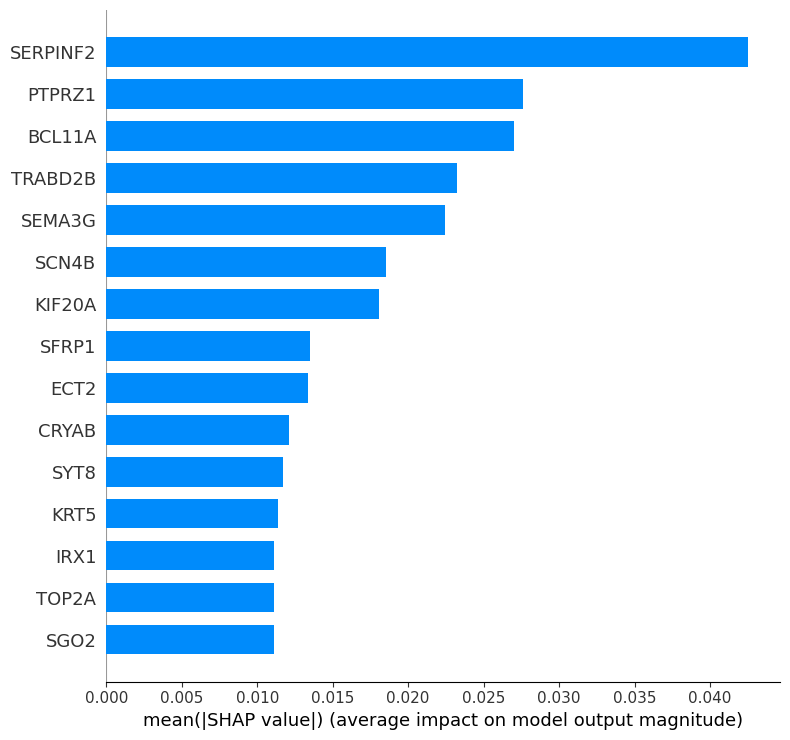

In [60]:
# Example: LumA
class_name = "LumA"
class_idx = list(brf_gini.classes_).index(class_name)

# Extract 2D SHAP values for this class
shap_vals_class = shap_values[:, :, class_idx]  # shape: (218, 30)

# Summary plot
shap.summary_plot(
    shap_vals_class,
    X_test_gini,
    max_display=15,
    plot_type="bar"
)


SHAP summary for Basal


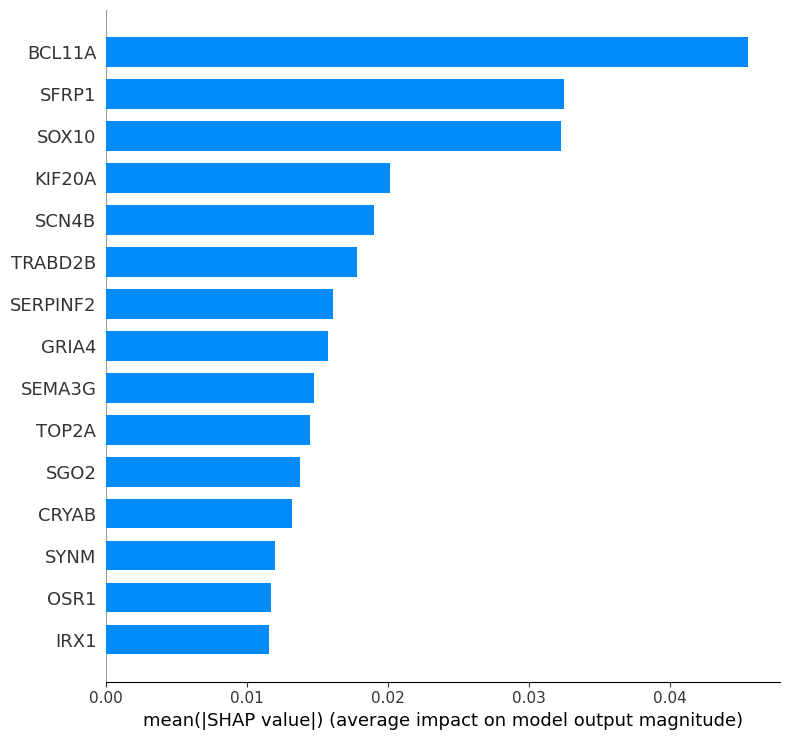

SHAP summary for HER2E


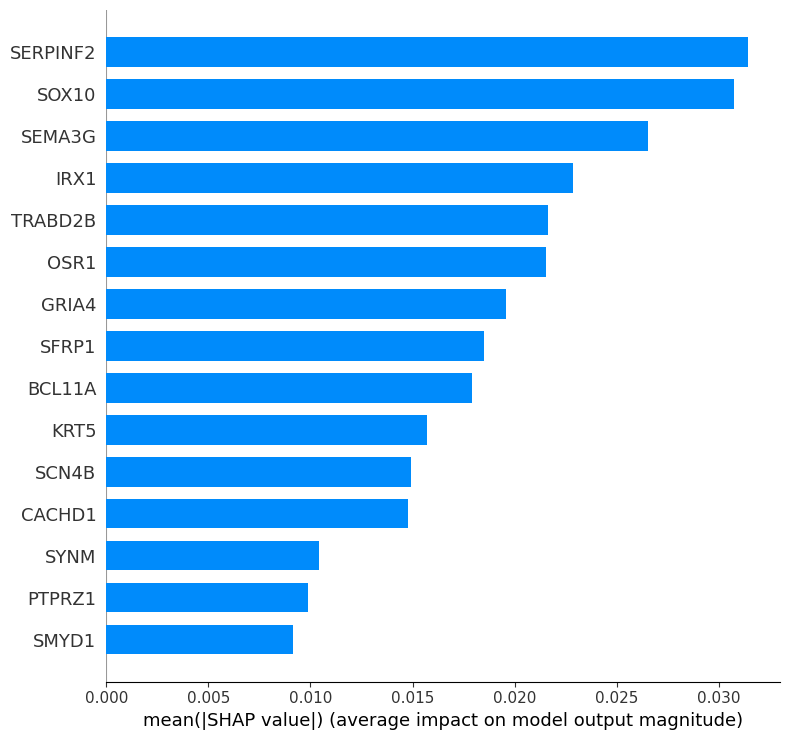

SHAP summary for LumA


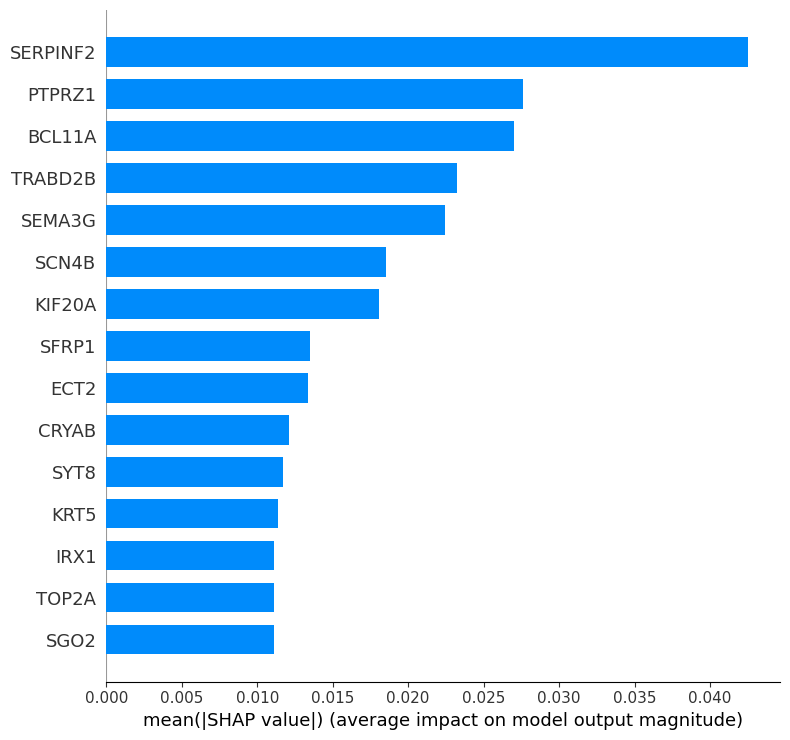

SHAP summary for LumB


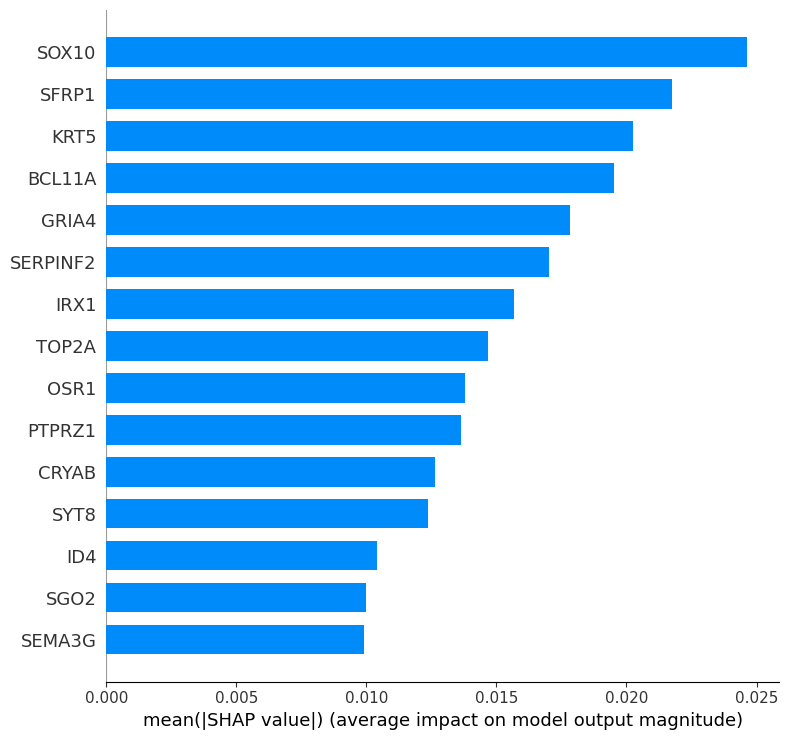

SHAP summary for Normal


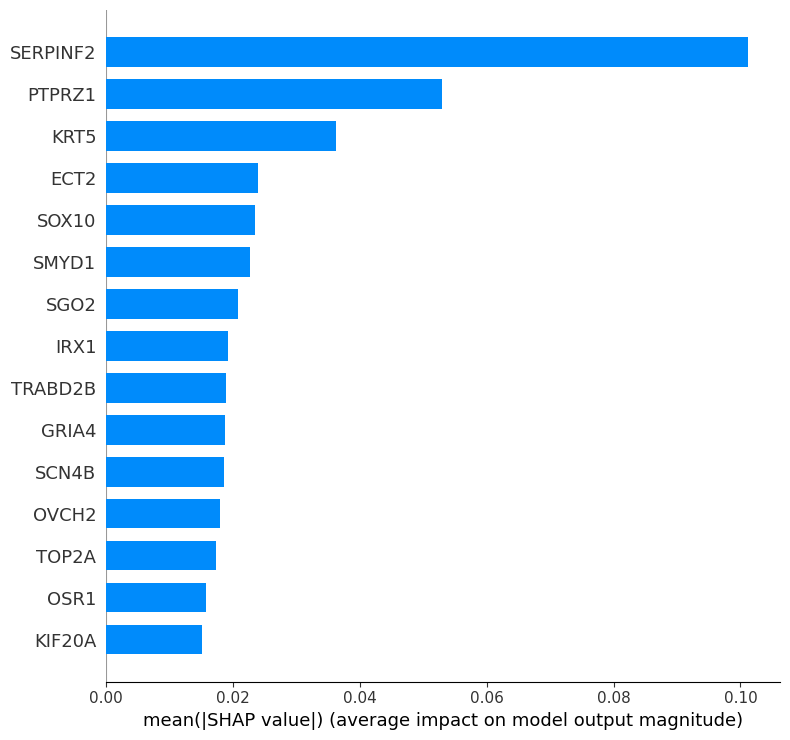

In [61]:
for cls_idx, cls_name in enumerate(brf_gini.classes_):
    shap_vals_class = shap_values[:, :, cls_idx]
    print(f"SHAP summary for {cls_name}")
    shap.summary_plot(
        shap_vals_class,
        X_test_gini,
        max_display=15,
        plot_type="bar"
    )


In [62]:
print(X_test_gini.columns.tolist())


['PTPRZ1', 'GRIA4', 'TRABD2B', 'OSR1', 'BCL11A', 'RHOJ', 'TAGLN', 'OVCH2', 'SCN4B', 'KRT5', 'SMYD1', 'CENPL', 'SEMA3G', 'SERPINF2', 'TOP2A', 'ID4', 'SYNM', 'SYT8', 'RGN', 'SFRP1', 'CACHD1', 'SOX10', 'KIF20A', 'IRX1', 'PPM1F', 'TF', 'SGO2', 'ECT2', 'CCDC178', 'CRYAB']


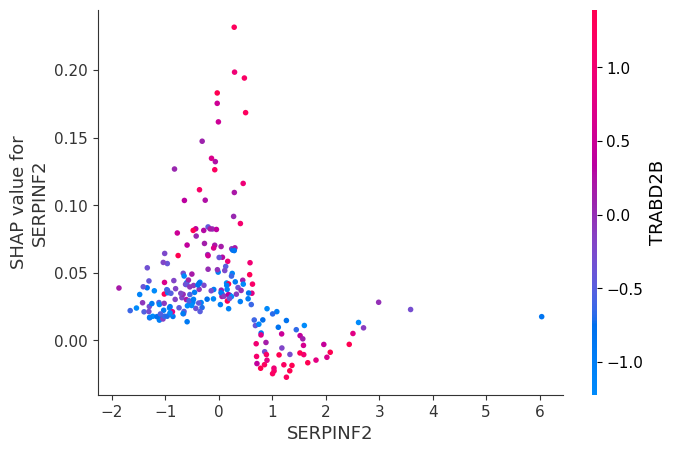

In [79]:
# Pick top gene from your validated list
top_gene = "SERPINF2"

# Class-specific SHAP values for LumA
class_name = "LumA"
class_idx = list(brf_gini.classes_).index(class_name)
shap_vals_class = shap_values[:, :, class_idx]  # shape: (n_samples, 30)

# Dependence plot
shap.dependence_plot(
    top_gene,
    shap_vals_class,
    X_test_gini
)


In [ ]:
#Biomarker discovery (Gini values and Permutation importance)
import pandas as pd
from sklearn.inspection import permutation_importance

# Top Gini genes (screening)

top_gini_genes = gini_importance.head(30).index.tolist()  # top 30 genes

# Subset data to top Gini genes

X_train_gini = X_train[top_gini_genes]
X_test_gini  = X_test[top_gini_genes]

# Refit Balanced Random Forest on top Gini genes
brf_gini = BalancedRandomForestClassifier(
    n_estimators=500,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)
brf_gini.fit(X_train_gini, y_train)


# Permutation importance (validation)

perm = permutation_importance(
    brf_gini,
    X_test_gini,
    y_test,
    n_repeats=20,
    random_state=42,
    n_jobs=-1,
    scoring="balanced_accuracy"
)

perm_importance = pd.Series(
    perm.importances_mean,
    index=X_test_gini.columns
).sort_values(ascending=False)


# Filter genes with positive permutation importance

validated_genes = perm_importance[perm_importance > 0].index.tolist()


# Intersection: robust biomarkers

final_biomarkers = list(set(top_gini_genes) & set(validated_genes))

print("Final robust biomarkers based on Gini + Permutation:\n")
print(final_biomarkers)


Final robust biomarkers based on Gini + Permutation:

['ECT2', 'SERPINF2', 'OSR1', 'TRABD2B', 'KIF20A', 'CRYAB', 'PTPRZ1', 'SGO2', 'CENPL', 'GRIA4', 'RGN', 'ID4', 'TOP2A', 'SYNM', 'SCN4B', 'KRT5', 'BCL11A', 'SEMA3G', 'TAGLN', 'SYT8', 'CACHD1']


In [65]:
import pandas as pd
import numpy as np

# shap_values: (n_samples, n_features, n_classes)
# We'll take mean absolute SHAP across all samples and classes

mean_abs_shap = np.abs(shap_values).mean(axis=(0, 2))  # shape: (n_features,)
shap_series = pd.Series(mean_abs_shap, index=X_test_gini.columns)


In [67]:
# Subset to final robust biomarkers
final_genes = ['ECT2', 'SERPINF2', 'OSR1', 'TRABD2B', 'KIF20A', 'CRYAB', 'PTPRZ1', 'SGO2', 
               'CENPL', 'GRIA4', 'RGN', 'ID4', 'TOP2A', 'SYNM', 'SCN4B', 'KRT5', 'BCL11A', 
               'SEMA3G', 'TAGLN', 'SYT8', 'CACHD1']

# Assemble DataFrame
biomarker_table = pd.DataFrame({
    "Gini_Importance": gini_importance[final_genes],
    "Permutation_Importance": perm_importance[final_genes],
    "Mean_SHAP": shap_series[final_genes]
})

# Rank by combined score (optional: sum or weighted)
biomarker_table["Combined_Rank"] = biomarker_table.rank(
    method="min", ascending=False
).mean(axis=1)

# Sort by combined rank
biomarker_table = biomarker_table.sort_values("Combined_Rank", ascending=False)

biomarker_table


,Gini_Importance,Permutation_Importance,Mean_SHAP,Combined_Rank
CRYAB,0.003935,0.003336,0.011871,17.666667
SYT8,0.004315,0.003250,0.010042,16.333333
ID4,0.004431,0.003758,0.007304,16.333333
RGN,0.004299,0.007369,0.006232,16.333333
TAGLN,0.006462,0.000718,0.004318,15.666667
ECT2,0.003978,0.007620,0.012224,15.000000
SYNM,0.004339,0.004276,0.008171,15.000000
CACHD1,0.004138,0.012108,0.007500,15.000000
SGO2,0.003982,0.014462,0.012355,13.333333
CENPL,0.004872,0.004457,0.007660,13.333333


In [68]:
biomarker_table["Final_Rank"] = biomarker_table["Combined_Rank"].rank(method="min", ascending=True)
biomarker_table = biomarker_table.sort_values("Final_Rank")
biomarker_table


,Gini_Importance,Permutation_Importance,Mean_SHAP,Combined_Rank,Final_Rank
BCL11A,0.006615,0.030555,0.023350,3.000000,1.0
PTPRZ1,0.010583,0.019300,0.022280,3.333333,2.0
TRABD2B,0.006900,0.026384,0.017773,3.666667,3.0
GRIA4,0.006977,0.026185,0.015626,4.333333,4.0
SERPINF2,0.004642,0.062632,0.041650,4.333333,4.0
KRT5,0.005704,0.014691,0.018905,6.666667,6.0
SEMA3G,0.004806,0.021060,0.016931,7.000000,7.0
TOP2A,0.004631,0.018772,0.012452,10.000000,8.0
SCN4B,0.006132,0.003762,0.015334,10.333333,9.0
OSR1,0.006693,0.000657,0.014623,11.333333,10.0


Mapping identified biomarkers to PAM50

In [69]:
PAM50_GENES = {
    "ACTR3B","ANLN","BAG1","BCL2","BIRC5","BLVRA","CCNB1","CCNE1","CDC20",
    "CDC6","CENPF","CEP55","CXXC5","EGFR","ERBB2","ESR1","EXO1","FGFR4",
    "FOXC1","GPR160","GRB7","KIF2C","KRT14","KRT17","KRT5","MAPT","MDM2",
    "MELK","MIA","MKI67","MLPH","MYBL2","NAT1","ORC6","PGR","PHGDH",
    "PTTG1","RRM2","SFRP1","SLC39A6","TMEM45B","TYMS","UBE2C",
    "UBE2T","UBE2S","ZNF703"
}


In [70]:
pam50_biomarkers = [gene for gene in final_biomarkers if gene in PAM50_GENES]
non_pam50_biomarkers = [gene for gene in final_biomarkers if gene not in PAM50_GENES]

print("Overlap with PAM50 genes:\n", pam50_biomarkers)
print("\nBiomarkers not in PAM50:\n", non_pam50_biomarkers)


Overlap with PAM50 genes:
 ['KRT5']

Biomarkers not in PAM50:
 ['ECT2', 'SERPINF2', 'OSR1', 'TRABD2B', 'KIF20A', 'CRYAB', 'PTPRZ1', 'SGO2', 'CENPL', 'GRIA4', 'RGN', 'ID4', 'TOP2A', 'SYNM', 'SCN4B', 'BCL11A', 'SEMA3G', 'TAGLN', 'SYT8', 'CACHD1']


In [71]:
# Final robust biomarkers
final_biomarkers = biomarker_table.index.tolist()  # assuming gene names are the index


In [72]:
# Map to PAM50
pam50_biomarkers = [gene for gene in final_biomarkers if gene in PAM50_GENES]
non_pam50_biomarkers = [gene for gene in final_biomarkers if gene not in PAM50_GENES]

print("Overlap with PAM50 genes:\n", pam50_biomarkers)
print("\nBiomarkers not in PAM50:\n", non_pam50_biomarkers)

Overlap with PAM50 genes:
 ['KRT5']

Biomarkers not in PAM50:
 ['BCL11A', 'PTPRZ1', 'TRABD2B', 'GRIA4', 'SERPINF2', 'SEMA3G', 'TOP2A', 'SCN4B', 'OSR1', 'KIF20A', 'CENPL', 'SGO2', 'CACHD1', 'SYNM', 'ECT2', 'TAGLN', 'ID4', 'SYT8', 'RGN', 'CRYAB']


In [73]:
# Initialize empty DataFrame
final_table = pd.DataFrame(columns=["Gene", "Subtype", "Mean_SHAP", "Direction",
                                    "Gini_Importance", "Permutation_Importance", "PAM50"])

for cls_idx, cls_name in enumerate(brf_gini.classes_):
    shap_cls = shap_values[:, :, cls_idx]
    mean_shap = np.abs(shap_cls).mean(axis=0)
    direction = shap_cls.mean(axis=0)
    
    df_cls = pd.DataFrame({
        "Gene": X_test_gini.columns,
        "Subtype": cls_name,
        "Mean_SHAP": mean_shap,
        "Direction": direction,
        "Gini_Importance": gini_importance[X_test_gini.columns].values,
        "Permutation_Importance": perm_importance[X_test_gini.columns].values,
        "PAM50": [gene in PAM50_GENES for gene in X_test_gini.columns]
    })
    
    # Only keep final robust biomarkers
    df_cls = df_cls[df_cls["Gene"].isin(final_biomarkers)]
    
    final_table = pd.concat([final_table, df_cls], axis=0)

# Reset index
final_table = final_table.reset_index(drop=True)

final_table.head(10)


,Gene,Subtype,Mean_SHAP,Direction,Gini_Importance,Permutation_Importance,PAM50
0,PTPRZ1,Basal,0.007384,0.005862,0.010583,0.019300,False
1,GRIA4,Basal,0.015712,0.011491,0.006977,0.026185,False
2,TRABD2B,Basal,0.017763,0.008106,0.006900,0.026384,False
3,OSR1,Basal,0.011719,-0.001557,0.006693,0.000657,False
4,BCL11A,Basal,0.045513,-0.008525,0.006615,0.030555,False
5,TAGLN,Basal,0.004278,0.002248,0.006462,0.000718,False
6,SCN4B,Basal,0.019008,0.009091,0.006132,0.003762,False
7,KRT5,Basal,0.010913,-0.000029,0.005704,0.014691,True
8,CENPL,Basal,0.009346,0.004164,0.004872,0.004457,False
9,SEMA3G,Basal,0.014719,0.007369,0.004806,0.021060,False


In [74]:
# Define CSV output path
csv_path = r"C:\Projects\BRCA_ML_Project\Data\Output\BRCA_robust_biomarkers_PAM50_mapping1.csv"

# Save final biomarker table as CSV
final_table.to_csv(csv_path, index=False)

print(f"CSV file saved successfully at:\n{csv_path}")


CSV file saved successfully at:
C:\Projects\BRCA_ML_Project\Data\Output\BRCA_robust_biomarkers_PAM50_mapping1.csv


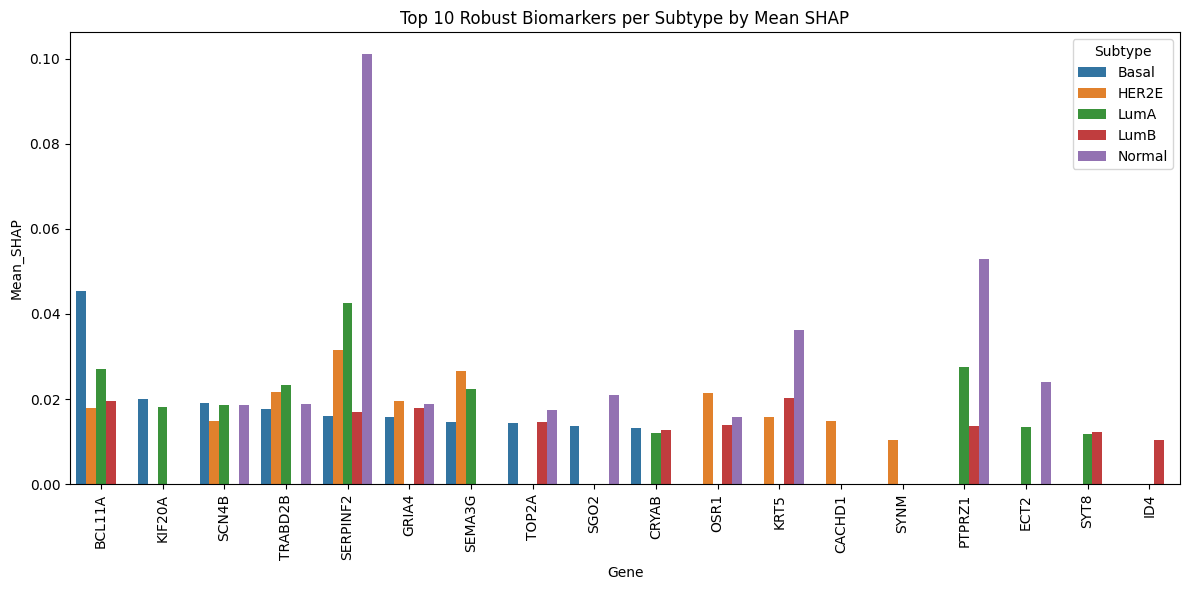

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter top 10 by Mean_SHAP per subtype
top_genes_per_subtype = final_table.groupby("Subtype").apply(lambda x: x.nlargest(10, "Mean_SHAP")).reset_index(drop=True)

plt.figure(figsize=(12,6))
sns.barplot(x="Gene", y="Mean_SHAP", hue="Subtype", data=top_genes_per_subtype)
plt.xticks(rotation=90)
plt.title("Top 10 Robust Biomarkers per Subtype by Mean SHAP")
plt.tight_layout()
plt.show()


In [76]:
# Add Tier based on PAM50 overlap and importance
def assign_tier(row):
    if row['PAM50']:
        return "Tier 1 (Strong)"
    elif row['Gene'] in final_biomarkers[:15]:  # top 15 novel genes by combined rank
        return "Tier 2 (Novel & High Importance)"
    else:
        return "Tier 3 (Exploratory)"

# Make a copy of final_table for recommendations
recommended_table = final_table.copy()

# Assign Tier
recommended_table['Tier'] = recommended_table.apply(assign_tier, axis=1)

# Keep relevant columns
recommended_table = recommended_table[[
    "Gene", "Subtype", "Mean_SHAP", "Direction", "Gini_Importance",
    "Permutation_Importance", "PAM50", "Tier"
]]

# Sort by Tier and Mean_SHAP descending
recommended_table = recommended_table.sort_values(
    by=['Tier', 'Mean_SHAP'], ascending=[True, False]
).reset_index(drop=True)

# Save as CSV
output_path = r"C:\Projects\BRCA_ML_Project\Data\Output\BRCA_recommended_biomarkers1.csv"
recommended_table.to_csv(output_path, index=False)

print(f"Recommended biomarkers table saved at:\n{output_path}")

# Display top rows
recommended_table.head(20)


Recommended biomarkers table saved at:
C:\Projects\BRCA_ML_Project\Data\Output\BRCA_recommended_biomarkers1.csv


,Gene,Subtype,Mean_SHAP,Direction,Gini_Importance,Permutation_Importance,PAM50,Tier
0,KRT5,Normal,0.036268,-0.027724,0.005704,0.014691,True,Tier 1 (Strong)
1,KRT5,LumB,0.020249,0.011269,0.005704,0.014691,True,Tier 1 (Strong)
2,KRT5,HER2E,0.015719,0.005665,0.005704,0.014691,True,Tier 1 (Strong)
3,KRT5,LumA,0.011375,0.010819,0.005704,0.014691,True,Tier 1 (Strong)
4,KRT5,Basal,0.010913,-0.000029,0.005704,0.014691,True,Tier 1 (Strong)
5,SERPINF2,Normal,0.101177,-0.080326,0.004642,0.062632,False,Tier 2 (Novel & High Importance)
6,PTPRZ1,Normal,0.052876,-0.046583,0.010583,0.019300,False,Tier 2 (Novel & High Importance)
7,BCL11A,Basal,0.045513,-0.008525,0.006615,0.030555,False,Tier 2 (Novel & High Importance)
8,SERPINF2,LumA,0.042502,0.039146,0.004642,0.062632,False,Tier 2 (Novel & High Importance)
9,SERPINF2,HER2E,0.031422,0.017118,0.004642,0.062632,False,Tier 2 (Novel & High Importance)


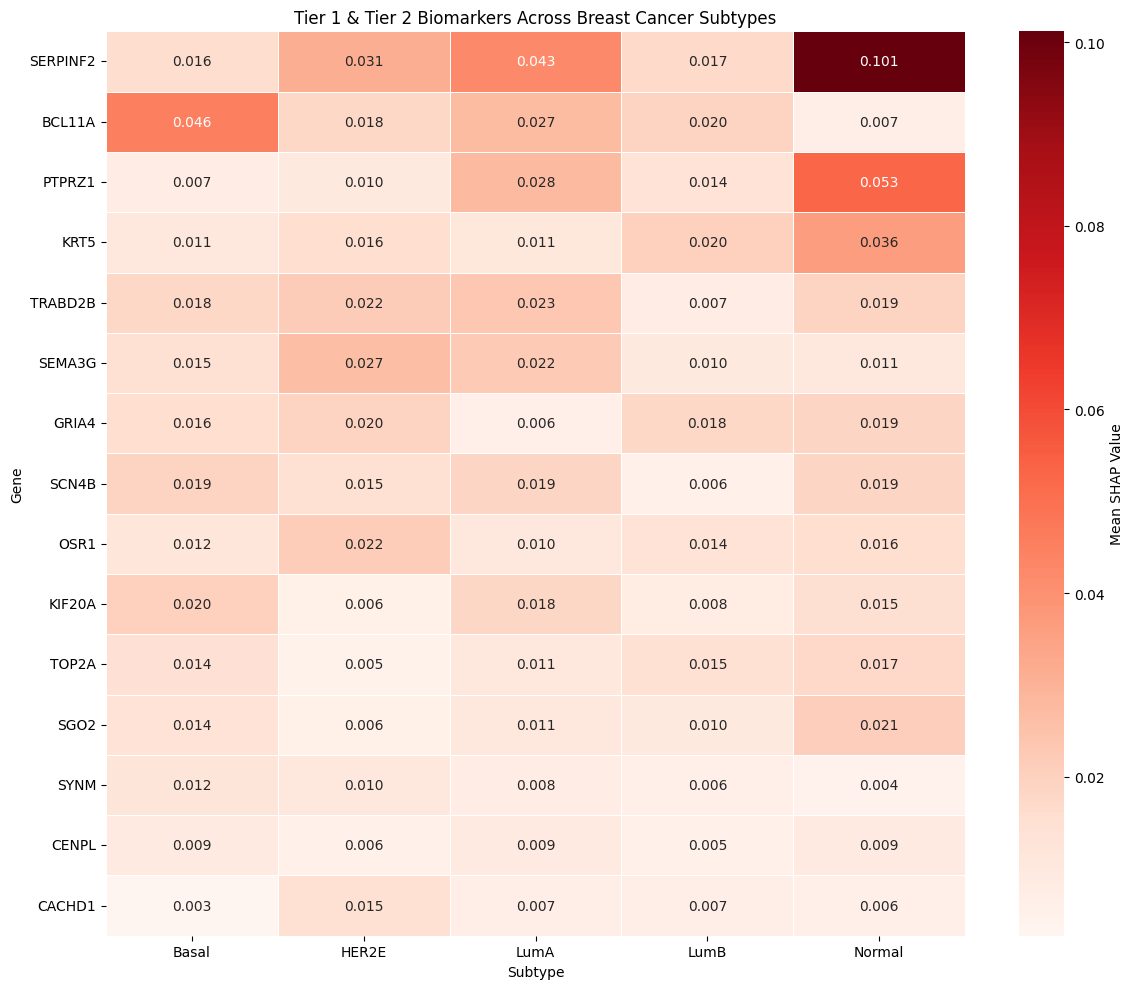

In [ ]:
#Heatmap _ importance of biomarkers for each cancer sub_type
'''This heatmap visualizes SHAP-derived importance of high-confidence biomarkers 
across breast cancer subtypes, highlighting subtype-specific and globally influential genes.'''

# Filter only Tier 1 & Tier 2 genes
plot_table = recommended_table[recommended_table['Tier'].isin(["Tier 1 (Strong)", "Tier 2 (Novel & High Importance)"])]

# Pivot table for heatmap: Genes vs Subtypes, values = Mean_SHAP
heatmap_data = plot_table.pivot_table(
    index='Gene',
    columns='Subtype',
    values='Mean_SHAP',
    aggfunc='mean'
).fillna(0)

# Sort genes by overall Mean_SHAP
gene_order = heatmap_data.mean(axis=1).sort_values(ascending=False).index
heatmap_data = heatmap_data.loc[gene_order]

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(
    heatmap_data,
    cmap="Reds",
    annot=True,
    fmt=".3f",
    linewidths=0.5,
    cbar_kws={'label': 'Mean SHAP Value'}
)
plt.title("Tier 1 & Tier 2 Biomarkers Across Breast Cancer Subtypes")
plt.ylabel("Gene")
plt.xlabel("Subtype")
plt.tight_layout()
plt.show()


In [78]:
plt.savefig(r"C:\Projects\BRCA_ML_Project\images\BRCA_biomarkers_heatmap2.png", dpi=300)
# Display it inline
plt.show()   # Ensures the plot renders before closing

<Figure size 640x480 with 0 Axes>

====================================END===================================